In [236]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, optimizers

In [237]:
# Prevenindo o uso de GPU (não compensa -- overhead maior que ganho)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [238]:
# seed para reprodutibilidade
np.random.seed(342016)

## Redes neurais

### CNN (Sequential)

In [239]:
dt = 0.01; T = 8; t = np.arange(0,T+dt,dt)
beta = 8/3; sigma = 10; rho = 28
nn_input = np.zeros((100*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

def lorenz_deriv(x_y_z,t0,sigma=sigma,beta=beta,rho=rho):
    x, y, z = x_y_z
    return [sigma*(y-x), x*(rho-z)-y, x*y-beta*z]

x0 = -15 + 30 * np.random.random((100, 3))
x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0])

for j in range(100):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]

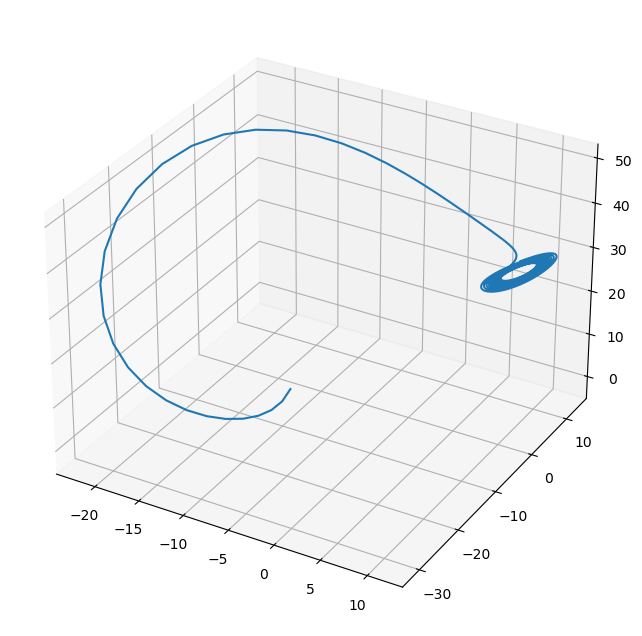

In [240]:
# (100, 801, 3)
# 100 trajetórias, 801 pontos, 3 dimensões
# plot de uma trajetória (3d)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
ax.plot(x_t[0,:,0], x_t[0,:,1], x_t[0,:,2])
plt.show()

In [241]:
net = keras.models.Sequential()
net.add(layers.Dense(10, input_dim=3, activation='sigmoid'))
net.add(layers.Dense(10, activation='relu'))
net.add(layers.Dense(3, activation='linear'))
net.compile(loss='mse', optimizer='adam')
History = net.fit(nn_input, nn_output, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 3s 928us/step - loss: 50.7508
Epoch 2/30
2500/2500 [==============================] - 2s 977us/step - loss: 2.4779
Epoch 3/30
2500/2500 [==============================] - 2s 894us/step - loss: 0.4716
Epoch 4/30
2500/2500 [==============================] - 2s 916us/step - loss: 0.1941
Epoch 5/30
2500/2500 [==============================] - 2s 824us/step - loss: 0.1143
Epoch 6/30
2500/2500 [==============================] - 2s 816us/step - loss: 0.0795
Epoch 7/30
2500/2500 [==============================] - 2s 812us/step - loss: 0.0598
Epoch 8/30
2500/2500 [==============================] - 2s 818us/step - loss: 0.0482
Epoch 9/30
2500/2500 [==============================] - 2s 824us/step - loss: 0.0399
Epoch 10/30
2500/2500 [==============================] - 2s 818us/step - loss: 0.0348
Epoch 11/30
2500/2500 [==============================] - 2s 827us/step - loss: 0.0305
Epoch 12/30
2500/2500 [==============================] - 2s 84

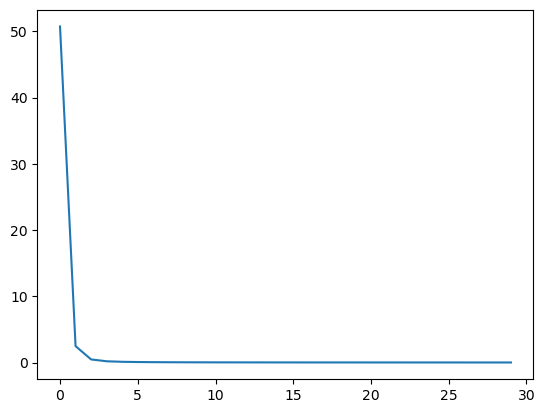

In [242]:
# plot loss history
plt.plot(History.history['loss'])

Melhor do que tentar prever próximos estados destas trajetórias existentes, vamos tentar prever o comportamento de duas trajetórias completamente novas (mas integrantes ao sistema para qual a rede foi treinada).

In [243]:
# 2 trajetórias
num_traj = 2

ynn = np.zeros((num_traj, len(t), 3))
ynn[:, 0, :] = -15 + 30 * np.random.random((num_traj, 3))
print(ynn.shape)
for jj, tval in enumerate(t[:-1]):
    ynn[:, jj+1, :] = net.predict(ynn[:, jj, :], verbose=1)

(2, 801, 3)
1/1 [==============================] - 0s 13ms/step


In [244]:
ynn.shape

(2, 801, 3)

In [245]:
# solve ODE, the two trajectories
y_t_1 = integrate.odeint(lorenz_deriv, ynn[0, 0, :], t)
y_t_2 = integrate.odeint(lorenz_deriv, ynn[1, 0, :], t)
y_t_1

array([[ 4.72297734,  9.97949775, 12.22511434],
       [ 5.25552904, 10.6588341 , 12.41155582],
       [ 5.80523182, 11.40311677, 12.68704748],
       ...,
       [-3.73892692, -4.66418307, 19.29354674],
       [-3.84076481, -4.95225963, 18.96559478],
       [-3.96124421, -5.25952431, 18.66300645]])

In [246]:
y_t_2

array([[-14.00846108,  -8.41626234,   2.62607521],
       [-13.63900285, -11.72992551,   3.93136858],
       [-13.60601553, -14.75998278,   5.60882133],
       ...,
       [  6.05668798,   7.56035759,  21.4724607 ],
       [  6.215466  ,   7.88675643,  21.37502976],
       [  6.39081652,   8.22583387,  21.31360589]])

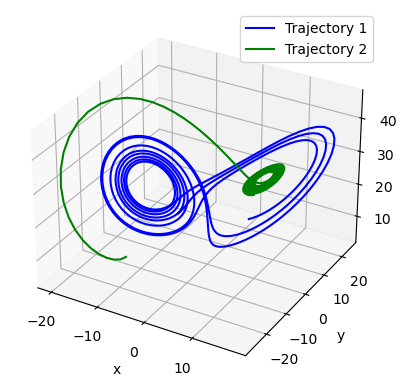

In [247]:
# plot y_t_1 and y_t_2 (blue and green)
# 3d
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(y_t_1[:, 0], y_t_1[:, 1], y_t_1[:, 2], 'b')
ax.plot(y_t_2[:, 0], y_t_2[:, 1], y_t_2[:, 2], 'g')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# blue label = trajectory 1
# green label = trajectory 2
plt.legend(['Trajectory 1', 'Trajectory 2'])
plt.show()

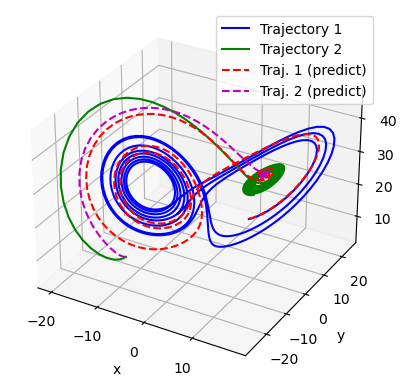

In [248]:
# plot y_t_1 and y_t_2 (blue and green)
# 3d
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(y_t_1[:, 0], y_t_1[:, 1], y_t_1[:, 2], 'b')
ax.plot(y_t_2[:, 0], y_t_2[:, 1], y_t_2[:, 2], 'g')
# ynn = np.zeros((num_traj, len(t), 3))
ynn_1 = ynn[0, :, :]
ynn_2 = ynn[1, :, :]
# plot ynn_1 (red, dotted line)
ax.plot(ynn_1[:, 0], ynn_1[:, 1], ynn_1[:, 2], 'r--')
# plot ynn_2 (pink, dotted line)
ax.plot(ynn_2[:, 0], ynn_2[:, 1], ynn_2[:, 2], 'm--')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# blue label = trajectory 1
# green label = trajectory 2
plt.legend(['Trajectory 1', 'Trajectory 2', 'Traj. 1 (predict)', 'Traj. 2 (predict)'])
plt.show()

In [249]:
# TODO: comentar melhor

### RNN (LSTM)

In [250]:
sequence_size = 40; train_size = 80; test_size = 20

rnn_input = np.zeros((train_size*(len(t)-sequence_size-1), sequence_size, 3))
rnn_output = np.zeros((train_size*(len(t)-sequence_size-1), 3))

for j in range(train_size):
    for k in range(len(t)-sequence_size-1):
        rnn_input[j*(len(t)-sequence_size-1) + k,:] = x_t[j,k:k+sequence_size,:]
        rnn_output[j*(len(t)-sequence_size-1) + k,:] = x_t[j,k+sequence_size,:]

model = keras.models.Sequential()
model.add(layers.LSTM(16, input_shape=(None, 3)))
# model.add(SimpleRNN(16, input_shape=(None, 3)))
model.add(layers.Dense(3))
sgd = optimizers.SGD(0.01)
model.compile(optimizer=sgd, loss='mean_squared_error')

2023-05-19 05:11:00.550671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 05:11:00.551984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 05:11:00.553216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [251]:
model.fit(rnn_input, rnn_output, epochs=50)

Epoch 1/50


2023-05-19 05:11:01.074553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 05:11:01.076313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 05:11:01.077633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1900/1900 [==============================] - 20s 10ms/step - loss: 9.3354
Epoch 2/50
1900/1900 [==============================] - 19s 10ms/step - loss: 1.8763
Epoch 3/50
1900/1900 [==============================] - 19s 10ms/step - loss: 1.0361
Epoch 4/50
1900/1900 [==============================] - 18s 10ms/step - loss: 0.8406
Epoch 5/50
1900/1900 [==============================] - 18s 9ms/step - loss: 0.6218
Epoch 6/50
1900/1900 [==============================] - 18s 10ms/step - loss: 0.5532
Epoch 7/50
1900/1900 [==============================] - 18s 10ms/step - loss: 0.4800
Epoch 8/50
1900/1900 [==============================] - 19s 10ms/step - loss: 0.7948
Epoch 9/50
1900/1900 [==============================] - 19s 10ms/step - loss: 0.4625
Epoch 10/50
1900/1900 [==============================] - 19s 10ms/step - loss: 0.3603
Epoch 11/50
1900/1900 [==============================] - 19s 10ms/step - loss: 0.3249
Epoch 12/50
1900/1900 [==============================] - 19s 10ms/step - lo

In [260]:
first_point = -15 + 30 * np.random.random((1, 3))
ynn = np.zeros((1, test_size, 3))
ynn[0, 0, :] = first_point

In [261]:
# solve ODE for the first point
y_t = integrate.odeint(lorenz_deriv, ynn[0, 0, :], t[:test_size])
y_t.shape

(20, 3)

In [262]:
for i in range(1, test_size):
    prediction = model.predict(ynn[:, :i, :])
    ynn[:, i, :] = prediction

1/1 [==============================] - 0s 16ms/step


In [263]:
ynn.shape

(1, 20, 3)

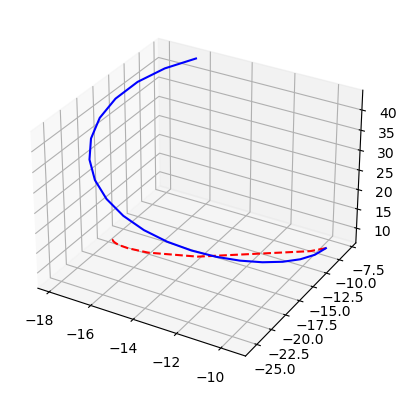

In [264]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(ynn[0, :, 0], ynn[0, :, 1], ynn[0, :, 2], 'r--')
ax.plot(y_t[:, 0], y_t[:, 1], y_t[:, 2], 'b')

## Métodos numéricos

### SINDy

TODO